# Metod potpornih vektora sa unakrsnom validacijom

In [1]:
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
import imblearn
import seaborn as sns # Paket za crtanje countplotova(vizuelno predstavljanje klasa kod nebalansiranosti)

### Učitavanje podataka

In [2]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'

In [4]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

In [5]:
def load_images(lowerIndex,upperIndex):
    x = []
    y = []
    width = 50
    height = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        image = cv2.imread(img)
        x.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [6]:
X,y = load_images(0,40000)

In [7]:
X = np.array(X)
y = np.array(y)

### Podela podataka na train i test skup

In [8]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

### Normalizacija

In [9]:
X_shape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_train = X_train.reshape(X_train.shape[0], X_shape)
X_test = X_test.reshape(X_test.shape[0],X_shape)

In [10]:
X_train = X_train.astype('float32')
X_train = X_train/255
X_test = X_test.astype('float32')
X_test = X_test/255

### Nebalansiranost klasa

Broj slika koje nemaju tumor:  20667
Broj slika koje imaju tumor:  6133


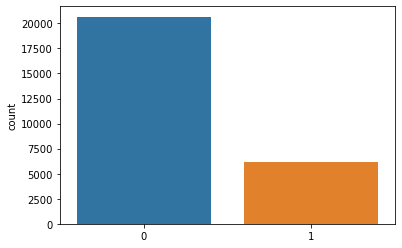

In [11]:
c = np.bincount(y_train)
print('Broj slika koje nemaju tumor: ', c[0])
print('Broj slika koje imaju tumor: ', c[1])
sns.countplot(y_train)
plt.show()

In [12]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state = 0,sampling_strategy = 'auto')
X_train, y_train = rus.fit_sample(X_train, y_train)

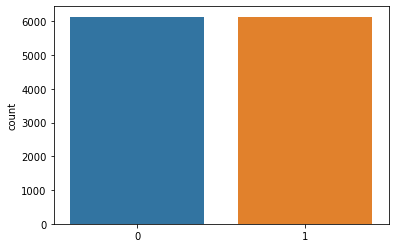

In [13]:
sns.countplot(y_train)
plt.show()

### Redukcija dimenzija pomoću PCA

In [14]:
pca = PCA()
pca.fit(X_train)

PCA()

In [15]:
var = np.cumsum(pca.explained_variance_ratio_)

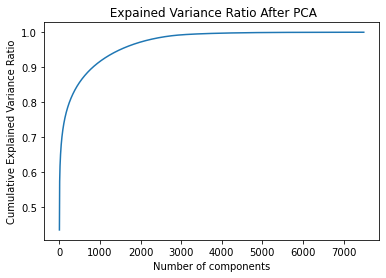

In [16]:
plt.plot(np.arange(X_shape),var)
plt.title(' Expained Variance Ratio After PCA')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [17]:
print('Broj komponenti koji opisuje 80% varijanse: ', np.where(var>=0.8)[0][0])

Broj komponenti koji opisuje 80% varijanse:  246


In [18]:
img_pca = PCA(n_components = 250)
img_pca.fit(X_train,y_train)
X_train = img_pca.transform(X_train)
X_test = img_pca.transform(X_test)

### Izbor hiperparametara unakrsnom validacijom

In [19]:
svm = svm.SVC()
param = {'C' : [10**i for i in range(-3,3)],
        'gamma' : [10**i for i in range(-3,3)]}

In [21]:
grid = model_selection.GridSearchCV(svm, param_grid = param, scoring = 'f1', cv = 3)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='f1')

In [22]:
print("best_score: {:.2f}" .format(grid.best_score_))
print("best_parameters: ", grid.best_params_)

best_score: 0.83
best_parameters:  {'C': 10, 'gamma': 0.001}


In [36]:
cv_results = pd.DataFrame(grid.cv_results_)

In [39]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,20.503203,0.412567,8.260142,0.026558,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.758127,0.768845,0.761989,0.762987,0.004432,11
1,20.186265,0.076826,8.291391,0.019492,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.754004,0.732209,0.773146,0.753120,0.016724,12
2,18.552459,0.039259,8.332700,0.073149,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.666558,0.000000,0.426898,0.364485,0.275677,35
3,18.358759,0.357894,8.754913,0.147309,0.001,1,"{'C': 0.001, 'gamma': 1}",0.666558,0.000000,0.666775,0.444444,0.314270,22
4,19.265163,0.214868,9.565706,0.380835,0.001,10,"{'C': 0.001, 'gamma': 10}",0.666558,0.000000,0.666775,0.444444,0.314270,22


In [48]:
cv_models = pd.DataFrame(np.array([cv_results['params'],cv_results['mean_test_score']]).transpose(), columns = ['params','mean_test_score'])

In [49]:
cv_models

,params,mean_test_score
0,"{'C': 0.001, 'gamma': 0.001}",0.762987
1,"{'C': 0.001, 'gamma': 0.01}",0.75312
2,"{'C': 0.001, 'gamma': 0.1}",0.364485
3,"{'C': 0.001, 'gamma': 1}",0.444444
4,"{'C': 0.001, 'gamma': 10}",0.444444
5,"{'C': 0.001, 'gamma': 100}",0.444444
6,"{'C': 0.01, 'gamma': 0.001}",0.790527
7,"{'C': 0.01, 'gamma': 0.01}",0.777451
8,"{'C': 0.01, 'gamma': 0.1}",0.364485
9,"{'C': 0.01, 'gamma': 1}",0.444444


### Učenje najboljeg modela i evaluacija

In [23]:
C = grid.best_params_['C']
gamma = grid.best_params_['gamma']

In [25]:
best_model = sklearn.svm.SVC(kernel = 'rbf', C=C, gamma=gamma)
best_model.fit(X_train,y_train)

SVC(C=10, gamma=0.001)

In [26]:
y_pred = best_model.predict(X_test)

In [27]:
score = metrics.accuracy_score(y_test,y_pred)
print('Tačnost modela: {:.2f}'  .format(score))

Tačnost modela: 0.82


In [28]:
f1_score = metrics.f1_score(y_test,y_pred)
print('F1 score modela: {:.2f}' .format(f1_score))

F1 score modela: 0.68


In [29]:
auc_score = metrics.roc_auc_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(auc_score))

auc_score modela: 0.83


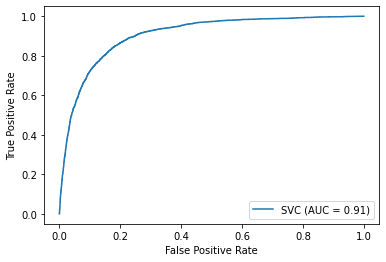

In [30]:
metrics.plot_roc_curve(best_model,X_test,y_test)
plt.show()

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     10179
           1       0.56      0.87      0.68      3021

    accuracy                           0.82     13200
   macro avg       0.76      0.83      0.78     13200
weighted avg       0.86      0.82      0.83     13200



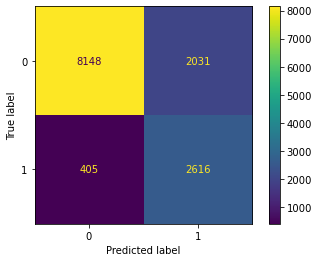

In [32]:
plot_confusion_matrix(best_model,X_test,y_test)
plt.show()

### Čuvanje modela

In [33]:
import pickle

In [34]:
file_name = 'models/svm_cross_val.model'
with open(file_name,'wb') as file:
    pickle.dump(best_model,file)